<a href="https://colab.research.google.com/github/DarkLord-13/Machine-Learning-01/blob/main/Background_Remover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Method-1

In [ ]:
!pip install rembg

In [ ]:
from rembg import remove
from PIL import Image

In [ ]:
img = Image.open('image1.jpg') # specify the input image path
img1 = remove(img)

img1.save('/content/bg_removed.png')

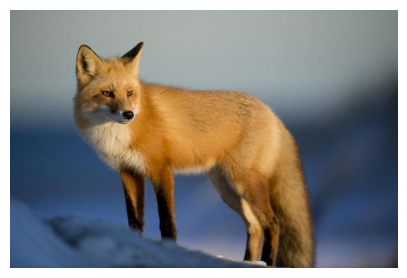

In [ ]:
sample_img = cv2.imread('image1.jpg')
plt.figure(figsize = [5, 4])
plt.axis('off')
plt.imshow(sample_img[:,:,::-1])
plt.show()

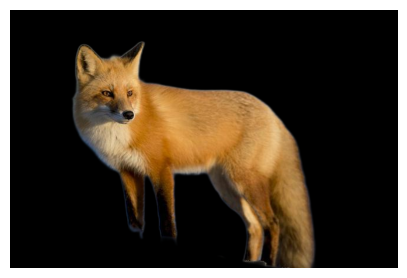

In [ ]:
sample_img = cv2.imread('/content/bg_removed.png')
plt.figure(figsize = [5, 4])
plt.axis('off')
plt.imshow(sample_img[:,:,::-1])
plt.show()

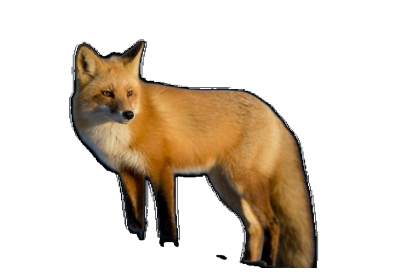

In [ ]:
import cv2
from matplotlib import pyplot as plt

# Read the image with transparency
sample_img = cv2.imread('/content/bg_removed.png', cv2.IMREAD_UNCHANGED)

if sample_img.shape[2] == 4:  # If it has 4 channels (RGBA)
    alpha_channel = sample_img[:, :, 3]

    white_background = 255 * np.ones_like(sample_img[:, :, :3], dtype=np.uint8)

    white_background[alpha_channel != 0] = sample_img[:, :, :3][alpha_channel != 0]

    plt.figure(figsize=[5, 4])
    plt.axis('off')
    plt.imshow(cv2.cvtColor(white_background, cv2.COLOR_BGR2RGB))
    plt.show()


# Method-2

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 44.1 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

In [ ]:
# initializing the model 'SelfieSegmentation()'
change_background_mp = mp.solutions.selfie_segmentation

change_bg_segment = change_background_mp.SelfieSegmentation()

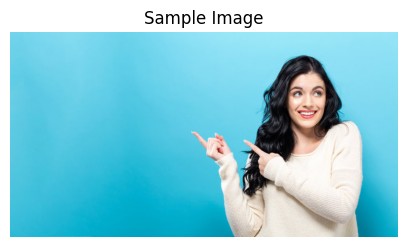

In [ ]:
sample_img = cv2.imread('image3.jpg')
plt.figure(figsize = [5, 4])
plt.title("Sample Image")
plt.axis('off')
plt.imshow(sample_img[:,:,::-1])
plt.show()

(-0.5, 680.5, 359.5, -0.5)

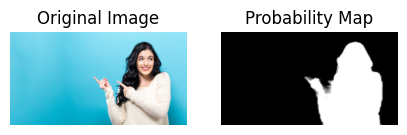

In [ ]:
RGB_sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

result = change_bg_segment.process(RGB_sample_img)

plt.figure(figsize=[5,4])

plt.subplot(121)
plt.imshow(sample_img[:,:,::-1])
plt.title("Original Image")
plt.axis('off');
plt.subplot(122)
plt.imshow(result.segmentation_mask, cmap='gray')
plt.title("Probability Map")
plt.axis('off')

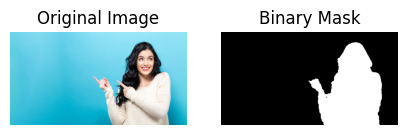

In [ ]:
binary_mask = result.segmentation_mask > 0.9

plt.figure(figsize=[5,4])
plt.subplot(121)
plt.imshow(sample_img[:,:,::-1])
plt.title("Original Image")
plt.axis('off');
plt.subplot(122)
plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Mask")
plt.axis('off');

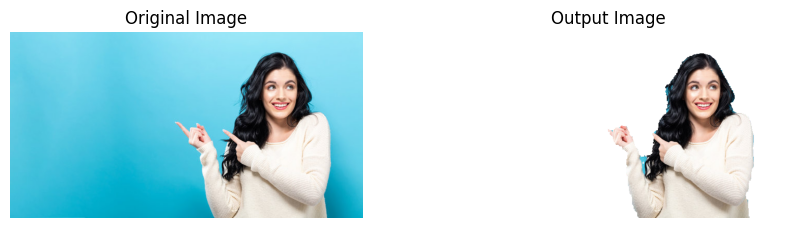

In [ ]:
binary_mask_3 = np.dstack((binary_mask,binary_mask,binary_mask))

output_image = np.where(binary_mask_3, sample_img, 255)

plt.figure(figsize=[10,4])

plt.subplot(121)
plt.imshow(sample_img[:,:,::-1])
plt.title("Original Image")
plt.axis('off');
plt.subplot(122)
plt.imshow(output_image[:,:,::-1])
plt.title("Output Image")
plt.axis('off');

# Method-3

In [ ]:
input_file = '/content/image.jpg'
output_file = '/content/final.jpg'

In [ ]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

def load_model():
  model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
  model.eval()
  return model

def make_transparent_foreground(pic, mask):
  # split the image into channels
  b, g, r = cv2.split(np.array(pic).astype('uint8'))
  # add an alpha channel with and fill all with transparent pixels (max 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # merge the alpha channel back
  alpha_im = cv2.merge([b, g, r, a], 4)
  # create a transparent background
  bg = np.zeros(alpha_im.shape)
  # setup the new mask
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  # copy only the foreground color pixels from the original image where mask is set
  foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)

  return foreground

def remove_background(model, input_file):
  input_image = Image.open(input_file)
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)

  foreground = make_transparent_foreground(input_image ,bin_mask)

  return foreground, bin_mask

In [ ]:
deeplab_model = load_model()
foreground, bin_mask = remove_background(deeplab_model, input_file)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 121MB/s]


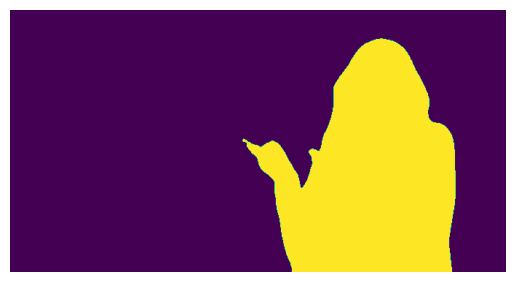

In [ ]:
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(bin_mask)

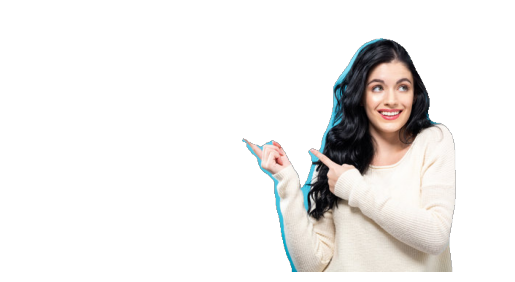

In [ ]:
plt.axis('off')
plt.imshow(foreground)